<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Deep_Autoencoder_Mnist_noisy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense,Conv2D,Input
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds

In [2]:
!pip install -qq wandb

     |████████████████████████████████| 1.7 MB 13.5 MB/s 
     |████████████████████████████████| 97 kB 6.6 MB/s 
     |████████████████████████████████| 180 kB 48.8 MB/s 
     |████████████████████████████████| 140 kB 48.4 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from wandb.keras import WandbCallback

In [5]:
config = {
    'learning_rate' : 0.01,
    'batch_size' : 64,
    'architecture' : 'deep autoencoder',
    'infra' : 'colab',
    'epochs' : 10,
    'dataset' : 'mnist',
    'loss' : 'binary_crossentropy',
    'optimizer' : 'adam'

}
wandb.init(
    project = 'deep autoencoder mnist',
    tags = ['baseline'],
    notes = 'first',
    config = config
)
config = wandb.config

wandb: Currently logged in as: prikshit (use `wandb login --relogin` to force relogin)


In [48]:
def noisy(image,labels):
    image = tf.cast(image,tf.float32)/255.0
    noise_factor = 0.5
    factor = noise_factor * tf.random.normal(image.shape)
    image_noisy = image + factor
    image_noisy = tf.clip_by_value(image_noisy,0.0,1.0)
    return image_noisy,image    

def preprocess(image,label):
    image = tf.cast(image,tf.float32)
    image = tf.reshape(image,(784,))
    image = image/255.0
    return image,image

In [49]:
train_dataset = tfds.load('mnist',split = 'train',as_supervised=True).map(noisy).shuffle(1024).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tfds.load('mnist',split = 'test',as_supervised=True).map(noisy).shuffle(1024).batch(config.batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [50]:
def encoder(inputs):
  '''Defines the encoder with two Conv2D and max pooling layers.'''
  conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(max_pool_1)
  max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv_2)

  return max_pool_2

In [51]:
def bottle_neck(inputs):
  '''Defines the bottleneck.'''
  bottle_neck = tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(bottle_neck)

  return bottle_neck, encoder_visualization

In [52]:
def decoder(inputs):
  '''Defines the decoder path to upsample back to the original image size.'''
  conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same')(inputs)
  up_sample_1 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_1)

  conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(up_sample_1)
  up_sample_2 = tf.keras.layers.UpSampling2D(size=(2,2))(conv_2)

  conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same')(up_sample_2)

  return conv_3

In [13]:
def autoencoder(inputs):
    encoder = Dense(128,activation = 'relu')(inputs)
    encoder = Dense(64,activation = 'relu')(encoder)

    encoder = Dense(32,activation = 'relu')(encoder)

    decoder  = Dense(64,activation  = 'relu')(encoder)
    decoder = Dense(128,activation  = 'relu')(decoder)
    decoder = Dense(784,activation = 'sigmoid')(decoder)

    encoder_output = Model(inputs = inputs , outputs = encoder)
    decoder_output  = Model(inputs = inputs, outputs = decoder)
    return encoder_output,decoder_output

In [53]:
def convolutional_auto_encoder():
  '''Builds the entire autoencoder model.'''
  inputs = tf.keras.layers.Input(shape=(28, 28, 1,))
  encoder_output = encoder(inputs)
  bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
  decoder_output = decoder(bottleneck_output)
  
  model = tf.keras.Model(inputs =inputs, outputs=decoder_output)
  encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
  return model, encoder_model

In [54]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 256)         295

In [55]:
train_steps = 60000 // config.batch_size
valid_steps = 60000 // config.batch_size

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')
conv_model_history = convolutional_model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=test_dataset, validation_steps=valid_steps, epochs=40)

Epoch 1/40
935/937 [============================>.] - ETA: 0s - loss: 0.1188WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 937 batches). You may need to use the repeat() function when building your dataset.


937/937 [==============================] - 32s 25ms/step - loss: 0.1187 - val_loss: 0.0982
Epoch 2/40
  1/937 [..............................] - ETA: 4:05 - loss: 0.0984WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 37480 batches). You may need to use the repeat() function when building your dataset.


937/937 [==============================] - 0s 75us/step - loss: 0.0984


In [ ]:
inputs = Input(shape = (784,))
encoder,model  = autoencoder(inputs)
model.compile(loss = config.loss , optimizer = config.optimizer)
model.fit(train_dataset,epochs = config.epochs,steps_per_epoch = 100)

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 64)                2112      
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dense_17 (Dense)            (None, 784)               1011

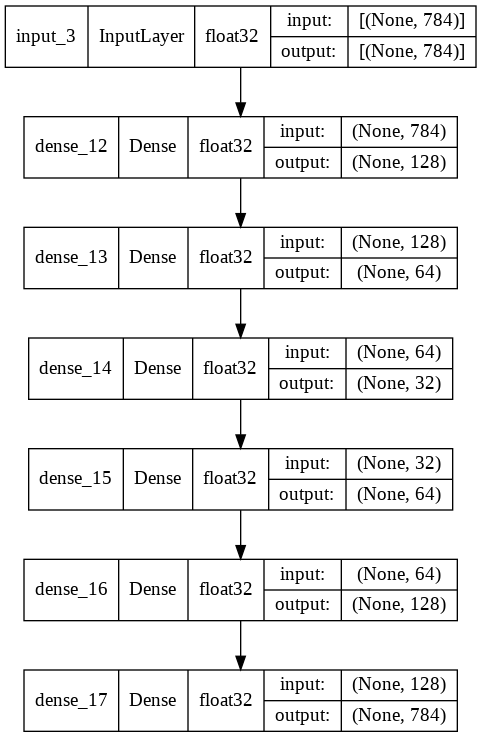

In [ ]:
plot_model(model,show_shapes = True,show_dtype=True)

In [59]:
def display_one_row(disp_images,offset,shape = (28,28)):
    for idx,test_image in enumerate(disp_images):
        plt.subplot(3,10,offset+idx+1)
        plt.yticks([])
        plt.xticks([])
        test_image  = tf.reshape(test_image,shape)
        plt.imshow(test_image,cmap = 'gray')

def display_results(disp_input_images,disp_enc_images,disp_dec_images,enc_shape = (7,7)):
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images,0)
    display_one_row(disp_enc_images , 10,enc_shape)
    display_one_row(disp_dec_images,20)

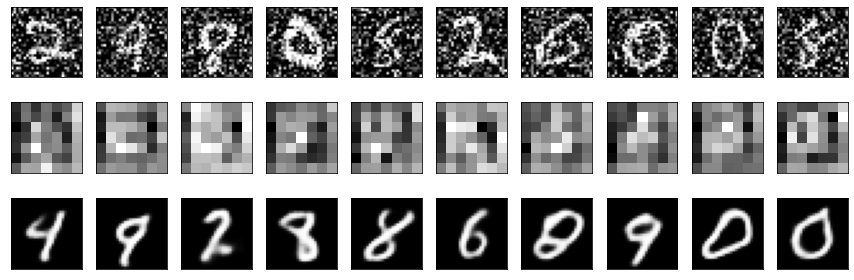

In [60]:
test_dataset = test_dataset.take(1)
output_samples = []
for input_image,image in tfds.as_numpy(test_dataset):
    output_samples = input_image
idxs = np.random.choice(config.batch_size,size = 10)
encoded_predicted = convolutional_encoder_model.predict(test_dataset)
simple_predicted = convolutional_model.predict(test_dataset)
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])